# Introduction to NLP Fundamentals in Tensorflow

Nlp has the goal of deriving information out of natural language could be sequences text or speech.
Another common term for NLP problems is sequence to sequence problems (seq2seq).

# Check for GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7eef7cd3-69b9-6b43-d722-87f3b9df7a71)


## Get helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys, make_confusion_matrix

--2024-02-06 18:36:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-06 18:36:45 (60.7 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



## Get a text dataset

The dataset we're going to be using is kraggle's inroduction to NLP dataset (text samples of Tweets labelled as disater or not disaster).
See original source here: https://www.kaggle.com/competitions/nlp-getting-started



In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

unzip_data("nlp_getting_started.zip")

--2024-02-06 17:33:12--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.182.207, 64.233.183.207, 173.194.193.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.182.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2024-02-06 17:33:12 (165 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualize the Dataset
To visualize our text samples, we first have to read them in, one way to do so would be to use python: https://realpython.com/read-write-files-python/

but I prefer to get visual straight away.

So another way to do this is to use pandas...


In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [ ]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state = 42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# What does the test dataframe looklike
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# how many total samples
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# Let visualize the random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", 'target']][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real diaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real diaster)
Text:
#SBNation #Flames What Makes a Good Penalty Killer? http://t.co/xYi5fDacxO http://t.co/SjtvzgGcXU

---

Target: 0 (not real diaster)
Text:
How is it one careless match can start a forest fire but it takes a whole box to start a campfire

---

Target: 1 (real disaster)
Text:
Let it be gone away like a dust in the wind .... Big Wind like a Tornado with Blizzard Thunder and Storm its that what I always want it

---

Target: 1 (real disaster)
Text:
@GeorgeFoster72 and The Wreck of the Edmund Fitzgerald

---

Target: 1 (real disaster)
Text:
Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/3bRme6Sn4t

---



# Split data into training and validation sets


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size = 0.1, # use 10% of training data for validation
                                                                            random_state = 42)

In [ ]:
# check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
# check the first training samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

# Converting text into numbers

When dealing with a text problem, one of the first things you'll have ro do before you can build a mdel is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenziation - direct mapping of token (a tken could be a word or a character) to number
* Embedding- create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

##  Text vextorization (tokenization)

In [ ]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens = 10000, # how many words in the vocabulary (automatically add <00v>)
                                    standardize = "lower_and_strip_punctuation",
                                    split= "whitespace",
                                    ngrams = None, # create groups of n-words?
                                    output_mode = "int", # how to map tokens to numbers
                                    output_sequence_length = None, # how long do you want your sequences to be?
                                    pad_to_max_tokens = True)

In [ ]:
len(train_sentences[0].split())

7

In [ ]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/ len(train_sentences))

15

In [ ]:
# setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does the model see?)

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = "int",
                                    output_sequence_length = max_length)

In [ ]:
# fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# create a sample sentence and tokenize text
sample_sentence = "There is a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 74,   9,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f'Original text:\n {random_sentence}\
       \n\nVectorized version:')
text_vectorizer([random_sentence])


Original text:
 Private thirsty night?SAD BLOOD ROCK'N ROLL? #??       

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[3516, 4427,    1,  353, 9019, 2310,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"number of words in vocab: {len(words_in_vocab)}"
      f"\n5 most common words: {top_5_words}"
      f"\n5 least common words: {bottom_5_words}")

number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating the Embedding using an embedding layer

To make our embedding, we're going to use an Embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequence being passed to the embedding layer

In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = max_vocab_length, # set input shape
                             output_dim = 128, # output shape
                             input_length = max_length # how long is each input
                             )
embedding

In [ ]:
# Get a random from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
       \n\nEmbedded version:")
# Embed the random snetence (turn it into dense vectors  of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 Why Some Traffic Is Freezing Cold And Some Blazing Hot ÛÒ And How To Heat Up Some Of Your Traffic http://t.co/C8b6DdiQIg       

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.0407985 ,  0.02227739, -0.00584284, ..., -0.03011866,
          0.04782419, -0.02511661],
        [-0.00447475, -0.04394546, -0.03082321, ..., -0.02811164,
          0.03361419,  0.01109085],
        [-0.04100077, -0.02712473, -0.03729223, ..., -0.0437682 ,
         -0.02010628,  0.00922772],
        ...,
        [ 0.0331299 ,  0.00201855, -0.03426876, ...,  0.02633044,
         -0.00331233, -0.01520001],
        [ 0.02436917, -0.04825387,  0.01584944, ...,  0.03320313,
          0.03636676, -0.04703858],
        [-0.01546446,  0.01689822, -0.00553056, ...,  0.04352293,
         -0.03904122,  0.02865287]]], dtype=float32)>

In [ ]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.0407985 ,  0.02227739, -0.00584284,  0.03092629, -0.04972123,
        -0.00245107,  0.02596059, -0.02633497, -0.00156151, -0.02470247,
         0.00692519,  0.01040707, -0.01150201,  0.03854429,  0.01711209,
        -0.02027379,  0.03483387, -0.04098935,  0.01578505, -0.00891012,
        -0.02444589, -0.03674058,  0.02253176,  0.00725098,  0.02796037,
        -0.03607471, -0.02302744,  0.01582226,  0.00782665,  0.03306632,
        -0.00082667, -0.01594424, -0.02409503, -0.03158442,  0.0383493 ,
         0.04700342,  0.03300363, -0.01945286, -0.00801494, -0.02510165,
        -0.04609251,  0.00495609, -0.03746816, -0.00495454,  0.04375544,
         0.00272464, -0.02979603, -0.03179562, -0.00666838,  0.01901143,
         0.01800903, -0.04717937,  0.04135502,  0.03907191, -0.01658753,
        -0.01689478, -0.04066519, -0.04444249,  0.02217035, -0.03110757,
         0.04687468, -0.01722265,  0.02645918, -0.02874099, -0.03286377,
  

## Modelling a text dataset (running a series of experiments)

Now we've a got way to turn our sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline), this is from Sklearn ML map: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1 : Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to approach all of these?

Use the standard steps in modelling with tensorflow

* create a model
* Build a model
* Fit a model
* Evaluate our model

##Model 0: Getting a baseline
As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using TF-IDF formula to convert our words to numbers.

  🔑Note: it's common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modellibf pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipleline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of : {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of : 79.27%


In [ ]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

## Creating an evaluation function for our model experiment

we could evaluate all of our model's predictions with different metrics every time, however thid will be cumbersome and with a fuction...
Let's create one to model's predictions with the truth labels using the following metrics:

* Accuracy
* Precision
* Recall
* F1-score

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculate model accuracy, precision, recall and f1 score of a binary classifucatiom model.
  """
  # calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average= "weighted" )
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true = val_labels,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

In [ ]:
# create a tensorboard callbacks (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"


In [ ]:
# Build model with the Functional API
from tensorflow.keras import layers, models
inputs = layers.Input(shape= (1,), dtype = tf.string) # input are 1 dimensional stings
x = text_vectorizer(inputs) # turn the inputs text into numbers
x = embedding(x) # create an embedding of the numberized inputs
# x = layers.Flatten()(x) # ihad to flatten the model out chape for it to be compartible with the train_labels
x = layers.GlobalAveragePooling1D()(x) # in the continuation of the video this actually turn the shape to one vector
outputs = layers.Dense(1, activation = "sigmoid")(x) # create the output layer,  want binary outputs so use sigmoid activation function
model_1 = models.Model(inputs, outputs, name = "model_1_dense")

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [ ]:
train_labels = train_labels.reshape(-1, 1)

In [ ]:
# compile model
model_1.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])



# Fit the model
model_1_history = model_1.fit(x = train_sentences,
                              y = train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                                                       experiment_name = "model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20240206-173316
Epoch 1/5
215/215 [==============================] - 9s 31ms/step - loss: 0.6114 - accuracy: 0.6935 - val_loss: 0.5362 - val_accuracy: 0.7507
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4410 - accuracy: 0.8171 - val_loss: 0.4660 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3463 - accuracy: 0.8612 - val_loss: 0.4588 - val_accuracy: 0.7940
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2833 - accuracy: 0.8914 - val_loss: 0.4662 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2373 - accuracy: 0.9118 - val_loss: 0.4791 - val_accuracy: 0.7861


In [ ]:
model_1.output_shape

(None, 1)

In [ ]:
train_labels.shape

(6851, 1)

In [ ]:
# check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4791 - accuracy: 0.7861


[0.4791383445262909, 0.7860892415046692]

In [ ]:
# Make some predictions and evaluate those
model_1_preds_probs = model_1.predict (val_sentences)
model_1_preds_probs.shape

24/24 [==============================] - 0s 2ms/step


(762, 1)

In [ ]:
model_1_preds_probs[0]

array([0.3445439], dtype=float32)

In [ ]:
# convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_preds_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [ ]:
# calculate our model_1 results
model_1_results = calculate_results(y_true = val_labels,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7916211438846743,
 'recall': 0.7860892388451444,
 'f1': 0.782856754224963}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

### Visualizing learned embeddings

In [ ]:
# Get the vocabulary from the txt vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [ ]:
# Get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for -5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()
print(embed_weights) # same size as vocab size and embedding_dim (output_dim of our embedding_layer)

[array([[-0.0221541 , -0.02391016, -0.00483258, ...,  0.05593106,
         0.02607674,  0.00939464],
       [-0.05100911, -0.00684214,  0.03275288, ..., -0.02198572,
        -0.02897969,  0.04155888],
       [-0.03132357,  0.0096302 , -0.02034035, ...,  0.0142318 ,
         0.0225021 , -0.03229135],
       ...,
       [ 0.02981668,  0.01111189, -0.03846873, ...,  0.00994277,
         0.04268372, -0.0282369 ],
       [-0.07345204, -0.05884987,  0.07440495, ...,  0.04021164,
         0.0122174 , -0.00083559],
       [-0.11574442, -0.03265173,  0.10611041, ...,  0.07467115,
        -0.10295202,  0.07363103]], dtype=float32)]


Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: https://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embeddings themselves: https://www.tensorflow.org/text/tutorials/word_embeddings

In [ ]:
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    if index >= len(embed_weights):
        print("Index", index, "is out of range for embed_weights.")
        break  # Exit loop or handle the error appropriately
    vec = embed_weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")

out_v.close()
out_m.close()


Index 1 is out of range for embed_weights.


In [ ]:
# Create embedding files (we got this from TensorFlow's word embeddings documentation)
# import io
# out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
# out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

# for index, word in enumerate(words_in_vocab):
#   if index == 0:
#     continue  # skip 0, it's padding.
#   vec = embed_weights[index]
#   out_v.write('\t'.join([str(x) for x in vec]) + "\n")
#   out_m.write(word + "\n")
# out_v.close()
# out_m.close()

In [ ]:
# Download files from colab to upload to pojector
try:
  from google.colab import files
  files.download("vectors.tsv")
  files.download("metadata.tsv")
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent Neural Networks (RNN'S)
RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representarion of a previous input to aid the representation of a later input.



### Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
```

In [ ]:
# Create an LSTM Model
from tensorflow.keras import layers
inputs = layers.Input(shape = (1,), dtype = "string")
x= text_vectorizer(inputs)
x = embedding(x)
# x = layers.LSTM(64, return_sequences = True)(x) # when you're stacking RNN cells together, you need to return_sequences= True
x = layers.LSTM(64)(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name = 'model_2_LSTM')

In [ ]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
# compile the model
model_2.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics= ["accuracy"])

In [ ]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20240206-173335
Epoch 1/5
215/215 [==============================] - 10s 37ms/step - loss: 0.2185 - accuracy: 0.9248 - val_loss: 0.5132 - val_accuracy: 0.7874
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1556 - accuracy: 0.9422 - val_loss: 0.6091 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1273 - accuracy: 0.9540 - val_loss: 0.7077 - val_accuracy: 0.7822
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1036 - accuracy: 0.9606 - val_loss: 0.8560 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0861 - accuracy: 0.9656 - val_loss: 0.9085 - val_accuracy: 0.7782


In [ ]:
# make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[5.4773465e-02],
       [8.5929352e-01],
       [9.9979943e-01],
       [7.2361864e-02],
       [4.8538920e-04],
       [9.9912053e-01],
       [9.7519445e-01],
       [9.9984002e-01],
       [9.9973434e-01],
       [5.7833064e-01]], dtype=float32)

In [ ]:
# convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# calculate model_2 results
model_2_results = calculate_results(y_true = val_labels,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 77.82152230971128,
 'precision': 0.7783689977394319,
 'recall': 0.7782152230971129,
 'f1': 0.7771462994602717}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 3: GRU
Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to a LSTM cell but has less parameters.

In [ ]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers

inputs = layers.Input(shape = (1,), dtype= tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences = True)(x) # if you to recurrent layers on top of each other, you need return_sequences = True
# x = layers.LSTM(64)(x)
# x = layers.GRU(64)(x)
# x = layers.Dense(64, activation = "relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name = "model_3_GRU")


In [ ]:
# get summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 1)                 

In [ ]:
# compile
model_3.compile(loss= "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
# Fit the model
model_3_history= model_3.fit(train_sentences,
                             train_labels,
                             epochs = 5,
                             validation_data = (val_sentences, val_labels),
                             callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                      "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20240206-173356
Epoch 1/5
215/215 [==============================] - 13s 47ms/step - loss: 0.1697 - accuracy: 0.9499 - val_loss: 0.6902 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1032 - accuracy: 0.9637 - val_loss: 0.8094 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0862 - accuracy: 0.9661 - val_loss: 0.7839 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0754 - accuracy: 0.9699 - val_loss: 0.8680 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0669 - accuracy: 0.9723 - val_loss: 1.0148 - val_accuracy: 0.7598


In [ ]:
# make predictions with our GRU
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[8.1737146e-02],
       [8.8103861e-01],
       [9.9991560e-01],
       [7.2508492e-02],
       [5.0712680e-04],
       [9.9636602e-01],
       [9.4765341e-01],
       [9.9997699e-01],
       [9.9997365e-01],
       [3.7328133e-01]], dtype=float32)

In [ ]:
# make some predictions with our GRU model
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# calculate model 3 results
model_3_results = calculate_results(y_true = val_labels,
                                    y_pred = model_3_preds)
model_3_results

{'accuracy': 75.98425196850394,
 'precision': 0.7615439957650938,
 'recall': 0.7598425196850394,
 'f1': 0.7574575318690253}

### Model4 : Bidirectional RNN
Normal RNN's go from left to right (just like you'd read an English sentences) however, a bidirectional RNN goes from right to left as well as left to right.

In [ ]:
from tensorflow.keras import layers
inputs = layers.Input(shape= (1,), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences = True))(x)
# print(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# x = layers.Dense()... you can cont.
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name = "model_4_bidirectional")


In [ ]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [ ]:
# compile
model_4.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
# fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20240206-173420
Epoch 1/5
215/215 [==============================] - 13s 41ms/step - loss: 0.1071 - accuracy: 0.9672 - val_loss: 1.0263 - val_accuracy: 0.7520
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0546 - accuracy: 0.9746 - val_loss: 1.1386 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0475 - accuracy: 0.9788 - val_loss: 1.3444 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0456 - accuracy: 0.9781 - val_loss: 1.3357 - val_accuracy: 0.7533
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0429 - accuracy: 0.9794 - val_loss: 1.3461 - val_accuracy: 0.7480


In [ ]:
# Make prediction with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


array([[6.4683817e-03],
       [5.1775891e-01],
       [9.9997211e-01],
       [1.9444701e-01],
       [5.9111004e-05],
       [9.9989104e-01],
       [9.7128737e-01],
       [9.9998629e-01],
       [9.9996412e-01],
       [9.8156381e-01]], dtype=float32)

In [ ]:
# convert the results of our bidirectional model
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
model_4_results = calculate_results(y_true = val_labels,
                                    y_pred = model_4_preds)
model_4_results

{'accuracy': 74.80314960629921,
 'precision': 0.7476890364000943,
 'recall': 0.7480314960629921,
 'f1': 0.7469781410673312}

## Convolution Neural Networks for Text (and other types of sequences)


We've used CNNs  for images but images are 2D (height x width)... however, our text data is 1D.

Previously we've Conv2D for our image data now we're going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):
```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities)
```

Model5 : Conv1D

In [ ]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentences"])) # turn target sequences into embedding
conv_1d = layers.Conv1D(filters = 32,
                        kernel_size = 5,
                        activation = 'relu',
                        padding = 'valid')
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to 'get the most important features' or 'get the features with highest values'


In [ ]:
# embedding_test

In [ ]:
# conv_1d_output

In [ ]:
# max_pooling_output

In [ ]:
#create 1-dimensioal convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters = 64, kernel_size= 5, strides = 1, activation = "relu", padding = "valid")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation = "relu" )(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name = "model_5_Conv1D")

# compile conv_1D
model_5.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Get a summary of our Conv1D model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)              

In [ ]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20240206-173446
Epoch 1/5
215/215 [==============================] - 10s 38ms/step - loss: 0.1198 - accuracy: 0.9619 - val_loss: 0.9089 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0712 - accuracy: 0.9737 - val_loss: 1.0389 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0592 - accuracy: 0.9765 - val_loss: 1.1101 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0549 - accuracy: 0.9778 - val_loss: 1.1453 - val_accuracy: 0.7520
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0482 - accuracy: 0.9796 - val_loss: 1.2651 - val_accuracy: 0.7467


In [ ]:
# Make some predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 4ms/step


array([[1.7358094e-01],
       [9.5989305e-01],
       [9.9995720e-01],
       [4.3281745e-02],
       [7.2968568e-08],
       [9.9790752e-01],
       [9.5625788e-01],
       [9.9994636e-01],
       [9.9999964e-01],
       [8.3318681e-01]], dtype=float32)

In [ ]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true = val_labels,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 74.67191601049869,
 'precision': 0.7470712708201386,
 'recall': 0.7467191601049868,
 'f1': 0.7448983201411337}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2")
embed_samples = embed([sample_sentence,
                       "When you can the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01602836  0.01068853  0.02425464 -0.01405768  0.01434428  0.08292627
  0.01963369  0.06160139 -0.00352701 -0.01216415  0.00978648 -0.01248499
  0.01232347  0.09748451  0.06141112 -0.03728352  0.01860887 -0.04669851
  0.00413913 -0.06363907 -0.02469896  0.02713692  0.02284444 -0.0021003
 -0.00630591 -0.0396496   0.02220406  0.00115075 -0.03132181  0.00119528
 -0.0401255   0.04561895 -0.01530597 -0.00175914  0.02173133 -0.08450424
  0.03340027  0.04604555 -0.0248025  -0.08681662  0.00702696 -0.00770477
 -0.01434537  0.07814164 -0.10676058 -0.05152996 -0.00858159 -0.03232229
 -0.03871096  0.02581471], shape=(50,), dtype=float32)


In [ ]:
embed_samples[0].shape

TensorShape([512])

In [ ]:
# create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                        input_shape = [],
                                        dtype = tf.string,
                                        trainable = False,
                                        name = "USE")

In [ ]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation ="relu"),
    layers.Dense(1, activation = "sigmoid")
], name = "model_6_USE")

# Compile
model_6.compile(loss= "binary_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics =["accuracy"])

In [ ]:

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:

# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data =(val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       'tf_hub_sentence_encoder')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20240206-173535
Epoch 1/5
215/215 [==============================] - 7s 19ms/step - loss: 0.5042 - accuracy: 0.7886 - val_loss: 0.4455 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4164 - accuracy: 0.8127 - val_loss: 0.4447 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4022 - accuracy: 0.8206 - val_loss: 0.4330 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3934 - accuracy: 0.8250 - val_loss: 0.4296 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3862 - accuracy: 0.8304 - val_loss: 0.4276 - val_accuracy: 0.8150


In [ ]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]


24/24 [==============================] - 1s 9ms/step


array([[0.17616418],
       [0.82358783],
       [0.98858684],
       [0.20828833],
       [0.7096726 ],
       [0.73944396],
       [0.9838833 ],
       [0.98079175],
       [0.93957436],
       [0.08404386]], dtype=float32)

In [ ]:
# convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(y_true = val_labels,
                                    y_pred = model_6_preds)
model_6_results

{'accuracy': 81.49606299212599,
 'precision': 0.8166816944448522,
 'recall': 0.8149606299212598,
 'f1': 0.8136303789632117}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.
To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data.

In [ ]:
# # create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", 'target']].sample(frac=0.1, random_state = 42)
# # train_10_percent.head(),len(train_10_percent)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [ ]:
# Maki1ng a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [ ]:
train_labels_10_percent.shape

(685, 1)

In [ ]:
pd.Series(np.array(train_labels_10_percent).reshape(-1)).value_counts()

0    406
1    279
dtype: int64

In [ ]:
pd.Series(np.array(tf.squeeze(train_labels_10_percent))).value_counts()

0    406
1    279
dtype: int64

In [ ]:
# train_sentences_10_percent["target"].value_counts()

In [ ]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model the same as a previous model you've created you can use the `tf.keras.models.clone_model()` method, see more here: https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [ ]:
# Let's build amodel the same as model_6
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss= "binary_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Get a sumary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       "tf_hub_sentences_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentences_10_percent_correct_split/20240206-173604
Epoch 1/5
22/22 [==============================] - 4s 47ms/step - loss: 0.6725 - accuracy: 0.6672 - val_loss: 0.6504 - val_accuracy: 0.7231
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.6042 - accuracy: 0.8146 - val_loss: 0.5944 - val_accuracy: 0.7717
Epoch 3/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5287 - accuracy: 0.8131 - val_loss: 0.5401 - val_accuracy: 0.7703
Epoch 4/5
22/22 [==============================] - 0s 21ms/step - loss: 0.4678 - accuracy: 0.8277 - val_loss: 0.5055 - val_accuracy: 0.7808
Epoch 5/5
22/22 [==============================] - 0s 21ms/step - loss: 0.4244 - accuracy: 0.8409 - val_loss: 0.4903 - val_accuracy: 0.7769


In [ ]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.18536124],
       [0.5862921 ],
       [0.914054  ],
       [0.36255905],
       [0.50268245],
       [0.6779304 ],
       [0.8803857 ],
       [0.7993148 ],
       [0.85924405],
       [0.17749666]], dtype=float32)

In [ ]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Evaluate model 7 predictions
model_7_results = calculate_results(y_true = val_labels,
                                    y_pred = model_7_preds)
model_7_results

{'accuracy': 77.69028871391076,
 'precision': 0.7775711689884918,
 'recall': 0.7769028871391076,
 'f1': 0.7754662769426549}

In [ ]:
# Evaluate model 7 predictions with no data leakage
model_7_results = calculate_results(y_true = val_labels,
                                    y_pred = model_7_preds)
model_7_results

{'accuracy': 77.69028871391076,
 'precision': 0.7775711689884918,
 'recall': 0.7769028871391076,
 'f1': 0.7754662769426549}

In [ ]:
model_6_results

{'accuracy': 81.49606299212599,
 'precision': 0.8166816944448522,
 'recall': 0.8149606299212598,
 'f1': 0.8136303789632117}

🔑 **Note:** Be *very* careful when creating when creating training/val/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of data outperforming the same model trained on 100% of data) trust your gut and go back through to find where the error may lie.


## Comparing the performance of each of our models


In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({
    "0_baseline" : baseline_results,
    "1_simple_dense" : model_1_results,
    "2_LSTM" : model_2_results,
    "3_gru" : model_3_results,
    "4_bidirectional" : model_4_results,
    "5_convid" : model_5_results,
    "6_tf_hub_use_encoder" : model_6_results,
    "7_tf_hub_use_encoder_10_percent" : model_7_results
})

In [ ]:
all_model_results = all_model_results.T

In [ ]:
all_model_results['accuracy'] = all_model_results['accuracy']/100

In [ ]:
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.786089,0.791621,0.786089,0.782857
2_LSTM,0.778215,0.778369,0.778215,0.777146
3_gru,0.759843,0.761544,0.759843,0.757458
4_bidirectional,0.748031,0.747689,0.748031,0.746978
5_convid,0.746719,0.747071,0.746719,0.744898
6_tf_hub_use_encoder,0.814961,0.816682,0.814961,0.813630
7_tf_hub_use_encoder_10_percent,0.776903,0.777571,0.776903,0.775466


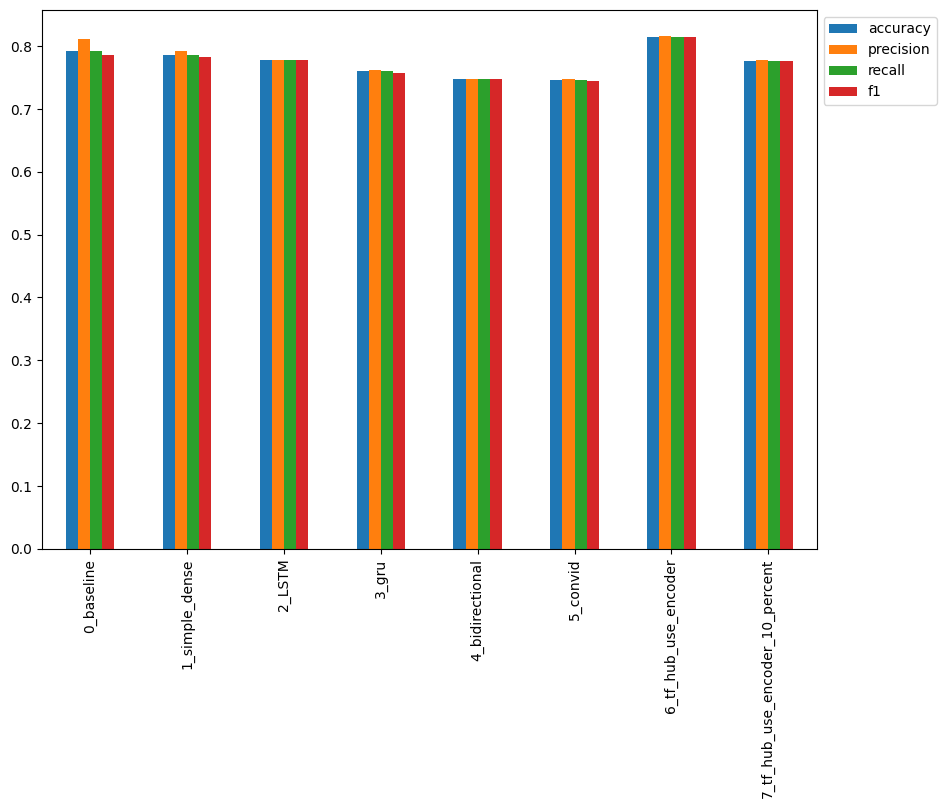

In [ ]:
# plot and compare all of the model results
all_model_results.plot(kind ="bar", figsize = (10, 7)).legend(bbox_to_anchor = (1.0, 1.0));

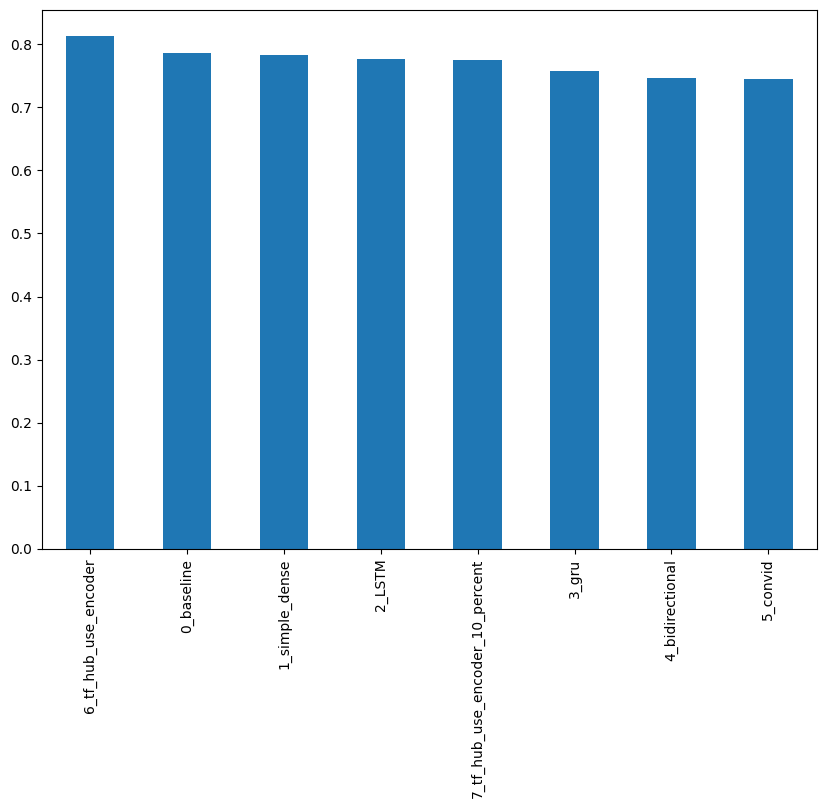

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending =False)['f1'].plot(kind = 'bar', figsize = (10, 7));

## Saving are main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The `SavedModel` format (this is the default when using TensorFlow)

In [ ]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load model with custom Hub layer (required HDF5 format)
import tensorflow_hub as hub
load_model_6 = tf.keras.models.load_model("model_6.h5",
                                          custom_objects = {"KerasLayer": hub.KerasLayer})

In [ ]:
# How does our loaded model perform?
load_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4276 - accuracy: 0.8150


[0.4275503158569336, 0.8149606585502625]

### Now let's to the `SavedModel` format...

In [ ]:
# Save TF Hub Sentence Encoder model to SaveModel format (default)
model_6.save("model_6_SavedModel_format")

In [ ]:
# Load in a model from the SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [ ]:
# Evaluate model in SavedModel format:
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4276 - accuracy: 0.8150


[0.4275503158569336, 0.8149606585502625]

## Finding the most wrong examples

* If our best model still isn't perfect, what wxamples is it getting wrong?
* Anf of these wrong examples which ones is it getting *most* wrong (those will predicition probabilities closest to the opposite class)

For example if a sample should habe a label of 0 but our model predicts a prediction probability of 0.999 (really close to 1) and vice versa.

In [ ]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2024-02-06 17:36:55--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.172.207, 209.85.200.207, 209.85.234.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.172.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   234MB/s    in 4.0s    

2024-02-06 17:36:59 (231 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.

In [ ]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [ ]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10] # these should be in label format

24/24 [==============================] - 1s 8ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Create DataFrame with validation sentences and best performing model prediction labels + probabilities
val_df = pd.DataFrame({'text': val_sentences,
                       'target': val_labels,
                       'pred' : model_6_pretrained_preds,
                       'pred_prob':tf.squeeze(model_6_pretrained_preds)})
val_df

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.0
1,FedEx no longer to transport bioterror germs i...,0,1.0,1.0
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,1.0
3,@camilacabello97 Internally and externally scr...,1,0.0,0.0
4,Radiation emergency #preparedness starts with ...,1,1.0,1.0
...,...,...,...,...
757,That's the ultimate road to destruction,0,0.0,0.0
758,@SetZorah dad why dont you claim me that mean ...,0,0.0,0.0
759,FedEx will no longer transport bioterror patho...,0,1.0,1.0
760,Crack in the path where I wiped out this morni...,0,1.0,1.0


In [ ]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values("pred_prob", ascending = False)
most_wrong[:10] # false positive

,text,target,pred,pred_prob
1,FedEx no longer to transport bioterror germs i...,0,1.0,1.0
317,Photo: postapocalypticflimflam: Prodding aroun...,0,1.0,1.0
397,The #tubestrike is because TFL workers may hav...,0,1.0,1.0
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,1.0
384,@nagel_ashley @Vicken52 @BasedLaRock @goonc1ty...,0,1.0,1.0
381,Deaths 3 http://t.co/nApviyGKYK,0,1.0,1.0
359,the windstorm blew thru my open window and now...,0,1.0,1.0
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,1.0
307,@pxnatosil @RenuncieDilma Fatality!,0,1.0,1.0
440,Do you have a plan? Emergency Preparedness for...,0,1.0,1.0


Let's remind ourselves of the target labels...
* 0 = not diaster
* 1 = diaster

In [ ]:
most_wrong.tail()

,text,target,pred,pred_prob
3,@camilacabello97 Internally and externally scr...,1,0.0,0.0
345,How to prepare your #property for a #storm:\n\...,1,0.0,0.0
110,Yelp Bolsters Health Care Reviews With Investi...,1,0.0,0.0
335,#computers #gadgets Two giant cranes holding a...,1,0.0,0.0
352,@reriellechan HE WAS THE LICH KING'S FIRST CAS...,1,0.0,0.0


In [ ]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n {text}\n")
  print("-----\n")

Target: 0, Pred: 1.0, Prob: 1.0
Text:
 FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday

-----

Target: 0, Pred: 1.0, Prob: 1.0
Text:
 Photo: postapocalypticflimflam: Prodding around the rubble. http://t.co/Bgy4i47j70

-----

Target: 0, Pred: 1.0, Prob: 1.0
Text:
 The #tubestrike is because TFL workers may have trouble planning downtime. I hope none need emergency services. http://t.co/iCSFDSiFqb

-----

Target: 0, Pred: 1.0, Prob: 1.0
Text:
 @SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

-----

Target: 0, Pred: 1.0, Prob: 1.0
Text:
 @nagel_ashley @Vicken52 @BasedLaRock @goonc1ty rip the world... its burning

-----

Target: 0, Pred: 1.0, Prob: 1.0
Text:
 Deaths 3 http://t.co/nApviyGKYK

-----

Target: 0, Pred: 1.0, Prob: 1.0
Text:
 the windstorm blew thru my open window and now my bong is in pieces just another example of nature's indifference to human suffering

-----

Target: 0, 

In [ ]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


## Making predictions on the test dataset

In [ ]:
test_sentences = test_df['text'].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects a list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("------\n")

1/1 [==============================] - 0s 43ms/step
Pred: 0, Prob: 0.03839287534356117
Text:
This game drove me to a rolo mini blizzard

------

1/1 [==============================] - 0s 40ms/step
Pred: 1, Prob: 0.9424379467964172
Text:
Flourishing sleigh bell an toothsome transit fatality: oNrhPz http://t.co/gB4W3T7b3T

------

1/1 [==============================] - 0s 39ms/step
Pred: 0, Prob: 0.07623162865638733
Text:
We need to stop paying attention to @drizzy body bagging @Meekmill and worry bout what happen to #SandraBland

------

1/1 [==============================] - 0s 39ms/step
Pred: 0, Prob: 0.20800045132637024
Text:
Truth...
https://t.co/n1K5nlib9X
#News
#BBC
#CNN
#Islam
#Truth
#god
#ISIS
#terrorism
#Quran
#Lies http://t.co/CGz84MUOCZ

------

1/1 [==============================] - 0s 37ms/step
Pred: 0, Prob: 0.11619940400123596
Text:
death is the only certainty in life

------

1/1 [==============================] - 0s 41ms/step
Pred: 0, Prob: 0.11822185665369034
Text:
@da

In [ ]:
test_sam1 = "Training with large minibatches is bad for your health. More importantly, it's bad for your test error. Friends dont let friends use minibatches larger than 32."
pred_prob = tf.squeeze(model_6_pretrained.predict([test_sam1]))
pred = tf.round(pred_prob)
print(f"Pred: {int(pred)}, Prob: {pred_prob}")
print(f"Text:\n{test_sam1}\n")
print("------\n")

1/1 [==============================] - 0s 41ms/step
Pred: 0, Prob: 0.0491056889295578
Text:
Training with large minibatches is bad for your health. More importantly, it's bad for your test error. Friends dont let friends use minibatches larger than 32.

------



In [ ]:
test_sam1= """If only the victims of the #LekkiMassacre knew some Nigerians would move on so fast and start campaigning for our oppressors they would have stayed back at home.
 People still don't understand what 2023 means for Nigeria. #Endsars was just the starting point !We must not forget!"""
pred_prob = tf.squeeze(model_6_pretrained.predict([test_sam1]))
pred = tf.round(pred_prob)
print(f"Pred: {int(pred)}, Prob: {pred_prob}")
print(f"Text:\n{test_sam1}\n")
print("------\n")

1/1 [==============================] - 0s 41ms/step
Pred: 1, Prob: 0.7316491603851318
Text:
If only the victims of the #LekkiMassacre knew some Nigerians would move on so fast and start campaigning for our oppressors they would have stayed back at home.
 People still don't understand what 2023 means for Nigeria. #Endsars was just the starting point !We must not forget!

------



## The speed/score tradeoff

In [ ]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [ ]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model = model_6_pretrained,
                                                            samples = val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 9ms/step


(0.3645963000000165, 0.00047847283464569096)

In [ ]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.0203006289999621, 2.664124540677441e-05)

In [ ]:
model_6_pretrained_results = calculate_results(y_true = val_labels,
                                               y_pred = model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

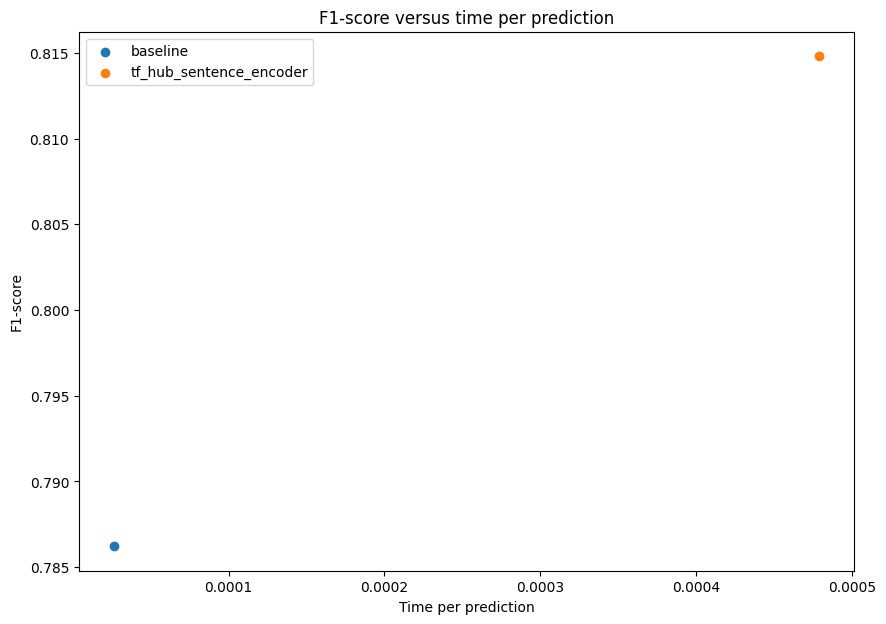

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label = "baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label ="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score");

In [ ]:
# Building model_1 using the Keras Sequential API
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, GlobalAveragePooling1D, GlobalMaxPooling1D

model_1s = Sequential([
    Input(shape = (1,), dtype = tf.string),
    text_vectorizer,
    embedding,
    # Dense(64, activation = "relu"),
    GlobalMaxPooling1D(),
    Dense(1, activation = "sigmoid")
], name = "model_1_seq")

In [ ]:
model_1s.compile(loss = "binary_crossentropy",
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics = ["accuracy"])
model_1s.summary()

Model: "model_1_seq"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d_2 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 1280129 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_model_1s = model_1s.fit(train_sentences,
                                train_labels,
                                epochs = 5,
                                validation_data = (val_sentences, val_labels),
                                callbacks = ([create_tensorboard_callback(SAVE_DIR,
                                                                            "SEQ.MODEL_1")]))

Saving TensorBoard log files to: model_logs/SEQ.MODEL_1/20240206-173726
Epoch 1/5
215/215 [==============================] - 9s 35ms/step - loss: 0.4493 - accuracy: 0.8932 - val_loss: 0.5031 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2156 - accuracy: 0.9578 - val_loss: 0.5169 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1433 - accuracy: 0.9653 - val_loss: 0.5622 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1080 - accuracy: 0.9696 - val_loss: 0.6055 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0866 - accuracy: 0.9737 - val_loss: 0.6502 - val_accuracy: 0.7743


In [ ]:
# Building LSTM model using Sequential API
from tensorflow.keras.layers import LSTM
model_2s = Sequential([
    Input(shape = (1,), dtype = tf.string),
    text_vectorizer,
    embedding,
    LSTM(64),
    # GlobalAveragePooling1D(),
    Dense(1, activation = "sigmoid")
], name = "lstm")

model_2s.compile(loss = "binary_crossentropy",
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics = ["accuracy"])

model_2s.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_model_2s = model_2s.fit(train_sentences,
                                train_labels,
                                epochs=5,
                                validation_data=(val_sentences, val_labels),
                                callbacks=[create_tensorboard_callback(SAVE_DIR, "lstm")])


Saving TensorBoard log files to: model_logs/lstm/20240206-173747
Epoch 1/5
215/215 [==============================] - 13s 55ms/step - loss: 0.1144 - accuracy: 0.9657 - val_loss: 0.8857 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 7s 32ms/step - loss: 0.0508 - accuracy: 0.9793 - val_loss: 1.1162 - val_accuracy: 0.7598
Epoch 3/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0414 - accuracy: 0.9810 - val_loss: 1.5764 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 6s 29ms/step - loss: 0.0405 - accuracy: 0.9806 - val_loss: 1.5483 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 5s 26ms/step - loss: 0.0398 - accuracy: 0.9818 - val_loss: 1.3963 - val_accuracy: 0.7651


In [ ]:
# Building conv1d using sequential api
from tensorflow.keras.layers import Conv1D

model_5s = Sequential([
    text_vectorizer,
    embedding,
    Conv1D(filters = 32, kernel_size = 5, activation = 'relu', padding = 'valid'),
    GlobalMaxPooling1D(),
    Dense(1, activation = "sigmoid")
], name = "conv1d")

model_5s.compile(loss = "binary_crossentropy",
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics = ['accuracy'])
model_5s.summary()

Model: "conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_3 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1300545 (4.96 MB)
Trainable params: 1300545 (4

In [ ]:
history_model_5s = model_5s.fit(train_sentences,
                                train_labels,
                                epochs=5,
                                validation_data=(val_sentences, val_labels),
                                callbacks=[create_tensorboard_callback(SAVE_DIR, "conv1d")])

Saving TensorBoard log files to: model_logs/conv1d/20240206-173825
Epoch 1/5
215/215 [==============================] - 9s 35ms/step - loss: 0.1095 - accuracy: 0.9692 - val_loss: 0.9290 - val_accuracy: 0.7638
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0558 - accuracy: 0.9790 - val_loss: 1.0611 - val_accuracy: 0.7546
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0480 - accuracy: 0.9797 - val_loss: 1.1397 - val_accuracy: 0.7520
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0450 - accuracy: 0.9804 - val_loss: 1.2126 - val_accuracy: 0.7572
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0444 - accuracy: 0.9807 - val_loss: 1.2250 - val_accuracy: 0.7533


In [ ]:
# 2.  Using 10 percent of data for the baseline model
model_0s = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()) # model to text
])
model_0s.fit(train_sentences_10_percent, train_labels_10_percent)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseliness = model_0s.score(val_sentences, val_labels)
print(f"baseline_10_percent:{baseliness *100: .2f}%"
      f"\nbaseline: {baseline_score * 100: .2f}%")

baseline_10_percent: 70.21%
baseline:  79.27%


In [ ]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True) # turn training on to fine-tune the TensorFlow Hub model

In [ ]:
# Create model using the Sequential API
model_6s = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(128, activation ="relu"),
    layers.Dense(64, activation ="relu"),
    layers.Dense(1, activation = "sigmoid")
], name = "model_6s")

# Compile
model_6s.compile(loss= "binary_crossentropy",
                optimizer= tf.keras.optimizers.Adam(0.0001),
                metrics =["accuracy"])

In [ ]:
model_6s.summary()

Model: "model_6s"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_12 (Dense)            (None, 128)               65664     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256871809 (979.89 MB)
Trainable params: 256871809 (979.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_model_6s = model_6s.fit(train_sentences,
                                train_labels,
                                epochs=5,
                                validation_data=(val_sentences, val_labels),
                                callbacks=[create_tensorboard_callback(SAVE_DIR, "model_6s")])

Saving TensorBoard log files to: model_logs/model_6s/20240206-174600
Epoch 1/5
215/215 [==============================] - 129s 469ms/step - loss: 0.2729 - accuracy: 0.9857 - val_loss: 0.5198 - val_accuracy: 0.8097
Epoch 2/5
215/215 [==============================] - 27s 126ms/step - loss: 0.0282 - accuracy: 0.9949 - val_loss: 0.6494 - val_accuracy: 0.8031
Epoch 3/5
215/215 [==============================] - 25s 117ms/step - loss: 0.0149 - accuracy: 0.9953 - val_loss: 0.7260 - val_accuracy: 0.7966
Epoch 4/5
215/215 [==============================] - 23s 108ms/step - loss: 0.0114 - accuracy: 0.9961 - val_loss: 0.8037 - val_accuracy: 0.8058
Epoch 5/5
215/215 [==============================] - 22s 105ms/step - loss: 0.0098 - accuracy: 0.9956 - val_loss: 0.8264 - val_accuracy: 0.8058


In [ ]:
# kaggle prediction
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [ ]:
test_sentences = test_df["text"].to_list()
pred_prob = model_6.predict(test_sentences)
preds = tf.squeeze(tf.round(pred_prob))
preds[:5]

102/102 [==============================] - 2s 16ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
id = test_df['id']
id

0           0
1           2
2           3
3           9
4          11
        ...  
3258    10861
3259    10865
3260    10868
3261    10874
3262    10875
Name: id, Length: 3263, dtype: int64

In [ ]:
preds = [int(pred) for pred in preds]

In [ ]:
test_s = pd.DataFrame({"id" : id,
                       "target": preds})
test_s.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
test_s.to_csv("/content/full_model_nlp_prediction1.csv", index = False)

In [ ]:
# Majority vote
ensemble_majority_vote = np.array([np.argmax(np.bincount(preds)) for preds in zip(model_1_preds, model_2_preds, model_3_preds, model_4_preds,
                                                                                  model_5_preds, model_6_preds)])

# Averaging prediction probabilities
ensemble_avg_probs = (model_1_preds+ model_2_preds+ model_3_preds +model_4_preds +model_5_preds+ model_6_preds) / 3

# Evaluate performance (for demonstration purposes)
true_labels = val_labels
accuracy_majority_vote = np.mean(ensemble_majority_vote == true_labels)
accuracy_avg_probs = np.mean(np.round(ensemble_avg_probs) == true_labels)

print("Accuracy (Majority Vote):", accuracy_majority_vote)
print("Accuracy (Averaging):", accuracy_avg_probs)

Accuracy (Majority Vote): 0.7782152230971129
Accuracy (Averaging): 0.484251968503937


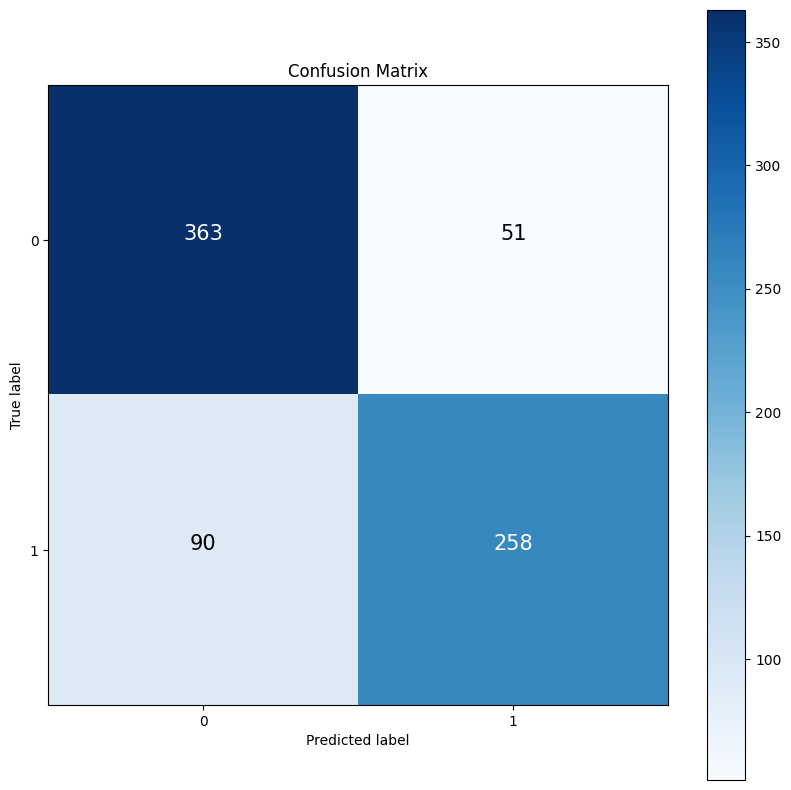

In [ ]:
make_confusion_matrix(val_labels, model_6_preds)